# Radix Tree Leaf Visualization

This notebook demonstrates how to build the radix tree with a larger `leaf_size` and visualize the axis-aligned bounding boxes for each leaf.

Steps covered:

- Generate a random 3D particle distribution within a bounding box.
- Build the radix tree with a configurable `leaf_size`.
- Plot particle positions and the bounding boxes of every leaf for visual inspection.

In [1]:
from yggdrax.tree import build_tree
from yggdrax.morton import morton_decode

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

In [2]:
# Generate toy 2D particles (embedded in 3D) and build the radix tree
key = jax.random.PRNGKey(0)
num_particles = 2048
key1, key2 = jax.random.split(key)
cluster1 = 0.2 * jax.random.normal(key1, (num_particles // 2, 2)) + jnp.array([-0.5, -0.3])
cluster2 = 0.2 * jax.random.normal(key2, (num_particles // 2, 2)) + jnp.array([0.4, 0.5])
positions_xy = jnp.concatenate([cluster1, cluster2], axis=0)
positions = jnp.concatenate([positions_xy, jnp.zeros((num_particles, 1))], axis=1)
masses = jnp.ones((num_particles,))
bounds = (
    jnp.array([-1.0, -1.0, -0.1]),
    jnp.array([1.0, 1.0, 0.1]),
)
leaf_size = 4
tree, pos_sorted, mass_sorted, inv = build_tree(
    positions,
    masses,
    bounds,
    return_reordered=True,
    leaf_size=leaf_size,
)
leaf_ranges = tree.node_ranges[tree.num_internal_nodes:]
print(f"Particles: {tree.num_particles}, leaf nodes: {leaf_ranges.shape[0]}")

Particles: 2048, leaf nodes: 512


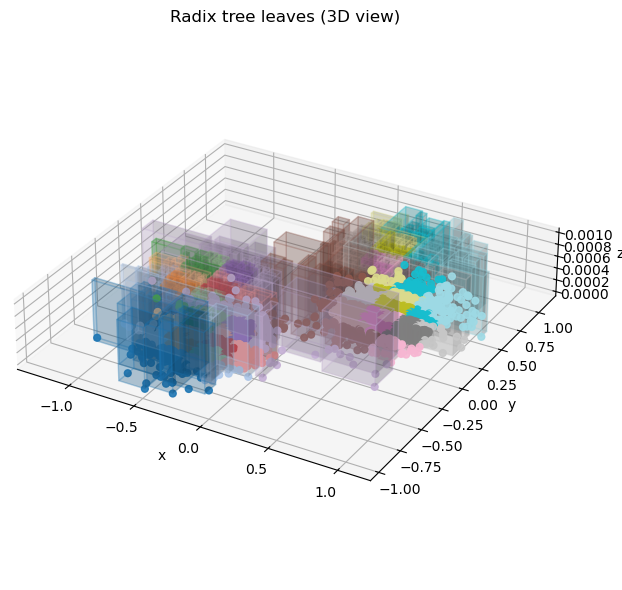

In [7]:
# Visualize particle positions and leaf bounding boxes (3D perspective)
pos_sorted_np = np.asarray(pos_sorted)
leaf_ranges_np = np.asarray(leaf_ranges)
leaf_ranges_int = leaf_ranges_np.astype(int)
leaf_colors = plt.cm.tab20(np.linspace(0.0, 1.0, leaf_ranges_int.shape[0]))
point_colors = np.zeros((pos_sorted_np.shape[0], 4))
for idx, (start, end) in enumerate(leaf_ranges_int):
    point_colors[start : end + 1] = leaf_colors[idx]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    pos_sorted_np[:, 0],
    pos_sorted_np[:, 1],
    pos_sorted_np[:, 2],
    s=24,
    alpha=0.9,
    c=point_colors
)
for idx, (start, end) in enumerate(leaf_ranges_int):
    pts = pos_sorted_np[start : end + 1]
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    dx, dy, dz = maxs - mins
    dz = float(max(dz, 1e-3))  # ensure thin boxes remain visible
    dx = float(max(dx, 1e-3))
    dy = float(max(dy, 1e-3))
    ax.bar3d(
        mins[0],
        mins[1],
        mins[2],
        dx,
        dy,
        dz,
        color=leaf_colors[idx],
        alpha=0.18,
        edgecolor=leaf_colors[idx],
        linewidth=1.0
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect((1.0, 1.0, 0.2))
handles = [
    Patch(facecolor=leaf_colors[idx], edgecolor=leaf_colors[idx], label=f"Leaf {idx}")
    for idx in range(leaf_ranges_int.shape[0])
]
#ax.legend(handles=handles, loc="upper left", title="Leaves")
ax.set_title("Radix tree leaves (3D view)")
plt.tight_layout()
plt.show()

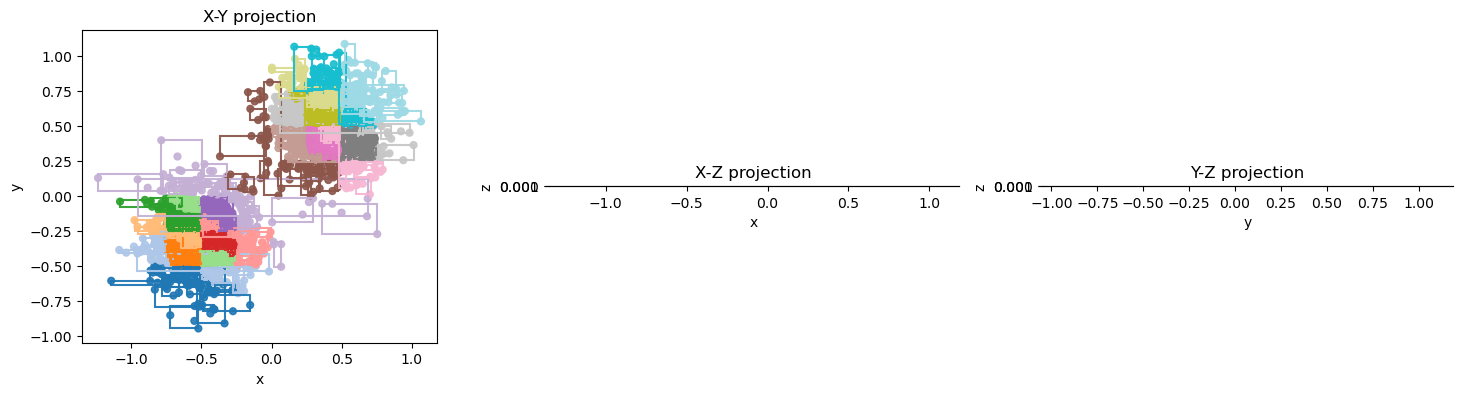

In [4]:
# Plot 2D projections for clearer leaf boundaries
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
projections = [
    (0, 1, "x", "y"),
    (0, 2, "x", "z"),
    (1, 2, "y", "z"),
]
handles = [
    Patch(facecolor=leaf_colors[idx], edgecolor=leaf_colors[idx], label=f"Leaf {idx}")
    for idx in range(leaf_ranges_int.shape[0])
]
for ax, (i, j, label_i, label_j) in zip(axes, projections):
    ax.scatter(
        pos_sorted_np[:, i],
        pos_sorted_np[:, j],
        s=24,
        c=point_colors,
        alpha=0.9
)
    for idx, (start, end) in enumerate(leaf_ranges_int):
        pts = pos_sorted_np[start : end + 1]
        mins = pts.min(axis=0)
        maxs = pts.max(axis=0)
        ax.add_patch(
            Rectangle(
                (mins[i], mins[j]),
                max(maxs[i] - mins[i], 1e-3),
                max(maxs[j] - mins[j], 1e-3),
                fill=False,
                edgecolor=leaf_colors[idx],
                linewidth=1.5,
                alpha=0.95
)
        )
    ax.set_xlabel(label_i)
    ax.set_ylabel(label_j)
    ax.set_title(f"{label_i.upper()}-{label_j.upper()} projection")
    ax.set_aspect("equal", adjustable="box")
#axes[0].legend(handles=handles, loc="upper right", title="Leaves")
plt.tight_layout()
plt.show()

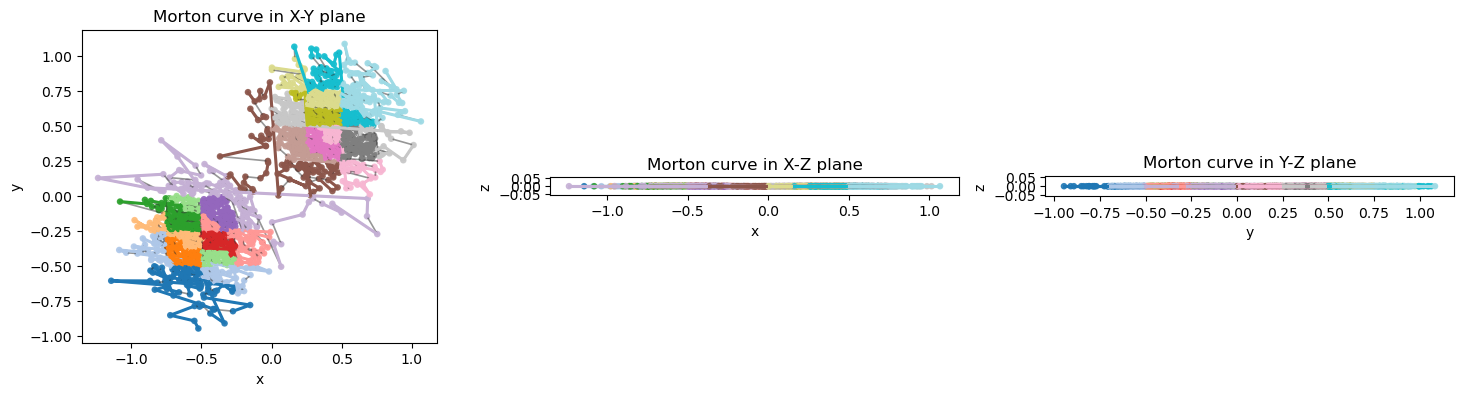

In [5]:
# Plot Morton (Z-order) traversal in the same projections
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
projections = [
    (0, 1, "x", "y"),
    (0, 2, "x", "z"),
    (1, 2, "y", "z"),
]
for ax, (i, j, label_i, label_j) in zip(axes, projections):
    ax.scatter(
        pos_sorted_np[:, i],
        pos_sorted_np[:, j],
        s=14,
        c=point_colors,
        alpha=0.85
)
    ax.plot(
        pos_sorted_np[:, i],
        pos_sorted_np[:, j],
        color="#2f2f2f",
        linewidth=1.2,
        alpha=0.5
)
    for idx, (start, end) in enumerate(leaf_ranges_int):
        pts = pos_sorted_np[start : end + 1]
        ax.plot(
            pts[:, i],
            pts[:, j],
            color=leaf_colors[idx],
            linewidth=2.2
)
    ax.set_xlabel(label_i)
    ax.set_ylabel(label_j)
    ax.set_title(f"Morton curve in {label_i.upper()}-{label_j.upper()} plane")
    ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

You can adjust `leaf_size` or the sampling distribution to inspect how the radix tree partitions space and how leaf densities change.

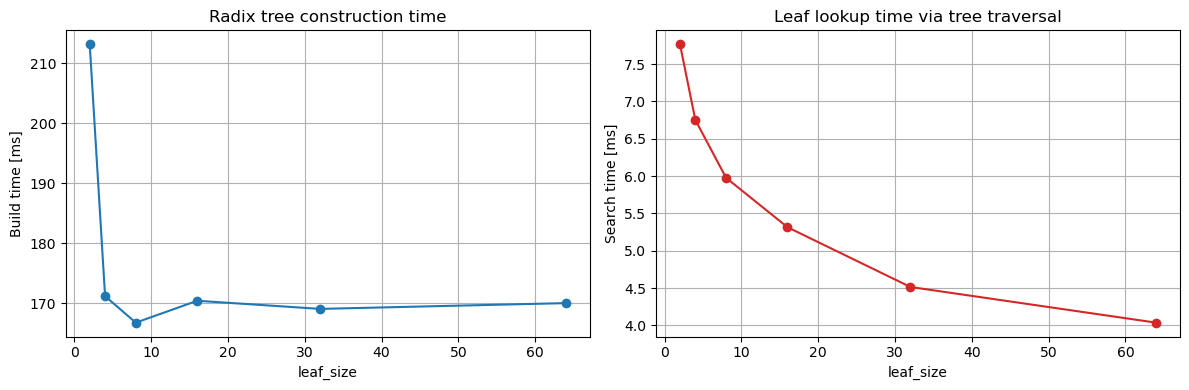

In [6]:
# Benchmark construction and tree search as a function of leaf size
import time

leaf_sizes = [2, 4, 8, 16, 32, 64]
build_times = []
search_times = []

# Warm-up to amortize JIT compilation cost
for ls in leaf_sizes:
    _ = build_tree(positions, masses, bounds, leaf_size=ls)

def locate_leaf(index, root, num_internal, left_child, right_child, node_ranges):
    node = root
    while node < num_internal:
        left = int(left_child[node])
        right = int(right_child[node])
        left_range = node_ranges[left]
        if left_range[0] <= index <= left_range[1]:
            node = left
        else:
            node = right
    return node - num_internal

for ls in leaf_sizes:
    t0 = time.perf_counter()
    tree, pos_s, mass_s, inv = build_tree(
        positions, masses, bounds, return_reordered=True, leaf_size=ls
    )
    tree.node_ranges.block_until_ready()
    tree.parent.block_until_ready()
    tree.left_child.block_until_ready()
    tree.right_child.block_until_ready()
    build_times.append(time.perf_counter() - t0)

    parent_np = np.asarray(tree.parent)
    left_child_np = np.asarray(tree.left_child)
    right_child_np = np.asarray(tree.right_child)
    node_ranges_np = np.asarray(tree.node_ranges)
    num_internal = tree.num_internal_nodes
    root_candidates = np.where(parent_np[:num_internal] == -1)[0]
    root = int(root_candidates[0]) if root_candidates.size else 0

    indices = np.arange(tree.num_particles)
    t1 = time.perf_counter()
    for idx in indices:
        locate_leaf(idx, root, num_internal, left_child_np, right_child_np, node_ranges_np)
    search_times.append(time.perf_counter() - t1)

build_times = np.array(build_times)
search_times = np.array(search_times)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(leaf_sizes, build_times * 1e3, marker="o")
ax[0].set_xlabel("leaf_size")
ax[0].set_ylabel("Build time [ms]")
ax[0].set_title("Radix tree construction time")
ax[0].grid(True)

ax[1].plot(leaf_sizes, search_times * 1e3, marker="o", color="#d62728")
ax[1].set_xlabel("leaf_size")
ax[1].set_ylabel("Search time [ms]")
ax[1].set_title("Leaf lookup time via tree traversal")
ax[1].grid(True)

plt.tight_layout()
plt.show()